# Univariate Relational Neural Control (RNC)

## Theoretical background

Human vision is mediated by a complex interconnected network of cortical brain areas that jointly represent visual information. While these areas are increasingly well understood in isolation, their representational relationships remain elusive: what representational content is shared between areas or unique to a specific area? Here we determined representational relationships by developing [Relational Neural Control (RNC)][rnc_website]. RNC generates and explores _in silico_ functional magnetic resonance imaging (fMRI) responses for large amounts of images, finding controlling images that align or disentangle responses across areas, under the assumption that alignment or disentanglement are indicative of shared or unique representational content, respectively. Together, this reveals how visual areas jointly represent the world as an interconnected network.

## Tutorial content

In this tutorial you will learn how to use **univariate RNC**, the RNC variant that controls in silico **univariate** fMRI responses (i.e., responses averaged over all voxels within an ROI), thus exploring representational relationships for visual information encoded in the strongest activation trends common across all ROI voxels.

To thoroughly explore the visual space in search for controlling stimuli, you will apply RNC to in silico fMRI responses for thousands of images generated through encoding models ([Naselaris et al., 2011][2011_naselaris]; [Wu et al., 2006][2006_wu]; [Yamins & DiCarlo, 2016][2016_yamins]) from the [Brain Encoding Response Generator (BERG)](https://github.com/gifale95/BERG). Specifically, you will use in silico fMRI responses for ~150,000 naturalistic images coming from the [Natural Scenes Dataset][nsd] ([Allen et al., 2022][allen]), the [ImageNet 2012 Challenge][imagenet] ([Russakovsky et al., 2015][russakovsky]), and the [THINGS Database][things] ([Hebart et al., 2019][hebart]).

<font color='red'><b>NOTE:</b></font> **Beyond familiarizing you with RNC, this tutorial and data can also be used for exploratory research and new discovery, while keeping in mind that the correctness of any finding should then be established through validation on _in vivo_ fMRI responses.**

## Additional tutorial information

You can run this tutorial either on [Colab][colab], or on [Jupyter Notebook][jupyter]. The running time of the tutorial ranges from 15 to 30 minutes, depending on the data algorithmic parameters used.

If you experience problems with the code please get in touch with Ale (alessandro.gifford@gmail.com).

For more information on RNC, please see our paper _[In silico discovery of representational relationships across visual cortex][paper_doi]_.

## Citations

If you use code and/or data from this tutorial, please cite:

> * Gifford AT, Jastrzębowska MA, Singer JJD, Cichy RM. 2025. In silico discovery of representational relationships across visual cortex. _Nature Human Behavior_. DOI: https://doi.org/10.1038/s41562-025-02252-z
> * Gifford AT, Bersch D, Roig G, Cichy RM. 2025. The Brain Encoding Response Generator. _In preparation_. https://github.com/gifale95/BERG

[rnc_website]: https://www.alegifford.com/projects/rnc/
[nest_website]: https://www.alegifford.com/projects/nest/
[2011_naselaris]: https://doi.org/10.1016/j.neuroimage.2010.07.073
[2006_wu]: https://doi.org/10.1146/annurev.neuro.29.051605.113024
[2016_yamins]: https://doi.org/10.1038/nn.4244
[imagenet]: https://www.image-net.org/challenges/LSVRC/2012/index.php
[russakovsky]: https://link.springer.com/article/10.1007/s11263-015-0816-y
[things]: https://things-initiative.org/
[hebart]: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0223792
[nsd]: https://naturalscenesdataset.org/
[allen]: https://www.nature.com/articles/s41593-021-00962-x
[colab]: https://colab.research.google.com/drive/1QpMSlvKZMLrDNeESdch6AlQ3qKsM1isO?usp=sharing
[jupyter]: https://github.com/gifale95/RNC/tutorials/univariate_rnc_tutorial.ipynb
[paper_doi]: https://doi.org/10.1038/s41562-025-02252-z

# 0 | Configuration

Note that in sections `0.1 Install and import the necessary Python libraries` and `0.2 Access the in silico fMRI responses` you will have to run different code cells based on whether you are running the tutorial on Colab or on Jupyter Notebook. An `if statement` will take care of this: you only need to select `'colab'` or `'jupyter_notebook'` for the `platform` variable below.

In [ ]:
platform = "colab" # @param ["colab", "jupyter_notebook"] {allow-input: true}

## 0.1 | Install and import the necessary Python libraries

### 0.1.1 | Install libraries, Google Colab

If you are running the tutorial on Google Colab, you do not need to install any library.

### 0.1.2 | Install libraries, Jupyter Notebook

If you are running the tutorial on Jupyter Notebook, you need to install the following libraries before running the tutorial:

[h5py][h5py], [jupyter][jupyter], [matplotlib][matplotlib], [numpy][numpy], [pillow][pil], [sklearn][sklearn], [torchvision][torchvision], [tqdm][tqdm].

[h5py]: https://docs.h5py.org/en/stable/
[jupyter]: https://jupyter.org/
[matplotlib]: https://matplotlib.org/stable/index.html
[numpy]: https://numpy.org/
[pil]: https://pypi.org/project/pillow/
[sklearn]: https://scikit-learn.org/stable/#
[torchvision]: https://pytorch.org/vision/stable/index.html
[tqdm]: https://github.com/tqdm/tqdm

### 0.1.3 | Import the libraries

Once you have installed all necessary libraries, import them with the following code.

In [ ]:
import h5py
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import os
from PIL import Image
import random
from sklearn.utils import resample
import torchvision
from torchvision import transforms as trn
from tqdm import tqdm

## 0.2 | Access the in silico fMRI responses

### 0.2.1 | Access the in silico fMRI responses on Google Colab

If you are running the tutorial on Google Colab you can use the pregenerated in silico fMRI responses the Google Drive public folder called [`pregenerated_insilico_neural_responses`][data]. Before running the tutorial code you need to right-click on this folder, and select `Organise` → `Add shortcut`. This will create a shortcut (without copying or taking space) of the folder to a desired path in your Google Drive, from which you can read the content after mounting using `drive.mount()`. Finally, edit the `data_dir` variable below with the path on your Drive to the `pregenerated_insilico_neural_responses` shortcut folder.

<font color='red'><b>NOTE:</b></font> **You need to manually create the data shortcut yourself, as the code cell below won't do this for you.**

[data]: https://drive.google.com/drive/folders/13miZhA7qc8LTG3QG5cZKMM1U4WOFm4z_?usp=drive_link

In [ ]:
if platform == 'colab':
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    data_dir = '/content/drive/MyDrive/pregenerated_insilico_neural_responses' #@param {type:"string"}

Mounted at /content/drive/


### 0.2.2 | Access the in silico fMRI responses on Jupyter Notebook

If you are running the tutorial on Jupyter Notebook you first need to download the in silico fMRI responses from the public Google Drive folder [`pregenerated_insilico_neural_responses`][data], and then edit the `data_dir` variable below with the path to the downloaded and unzipped data folder.

Note that the `pregenerated_insilico_neural_responses` folder contains several GBs of data, and thus the download might take a while. However, based on your needs you might choose to download only a part of it (i.e., only in silico fMRI responses of specific subjects or visual areas, or for specific image sets).

We recommend downloading the in silico fMRI responses directly from Google Drive via terminal using [Rclone][rclone]. [Here][guide] is a step-by-step guide for how to install and use Rclone to move files to and from your Google Drive. Before downloading the in silico fMRI responses via terminal you need to add a shortcut of the `pregenerated_insilico_neural_responses` folder to your Google Drive. You can do this by right-clicking on the `pregenerated_insilico_neural_responses` folder, and selecting `Organise` → `Add shortcut`. This will create a shortcut (without copying or taking space) of the folder to a desired path in your Google Drive, from which you can download its content.

[data]: https://drive.google.com/drive/folders/13miZhA7qc8LTG3QG5cZKMM1U4WOFm4z_?usp=drive_link
[rclone]: https://rclone.org/
[guide]: https://noisyneuron.github.io/nyu-hpc/transfer.html

In [ ]:
if platform == 'jupyter_notebook':
    data_dir = '../pregenerated_insilico_neural_responses' #@param {type:"string"}

# 1 | Load and visualize the data

Before applying RNC, in this section you will load and visualize the in silico fMRI responses, along with the corresponding images, and familiarize yourself with these data. However, if you are familiar with the data, you can skip this section altogether and directly apply RNC in section 2.

We generated the in silico fMRI responses using encoding models trained on single-trial fMRI betas from the [Natural Scenes Dataset (NSD)][nsd] ([Allen et al., 2022][allen]), a large-scale dataset of high-quality 7T fMRI responses from 8 subjects who each viewed 9,000–10,000 distinct color natural scenes. The encoding models consisted of the feature-weighted receptive field (fwRF), a convolutional neural network trained end-to-end to predict fMRI responses to images ([St-Yves & Naselaris, 2018][styves]; [Allen et al., 2022][allen]).

We trained a separate encoding model for each of the 8 NSD subjects, and for each of the following 23 visual ROIs:
* **Early retinotopic visual regions:** V1, V2, V3, hV4.
* **Body-selective regions:** EBA, FBA-2.
* **Face-selective regions:** OFA, FFA-1, FFA-2.
* **Place-selective regions:** OPA, PPA, RSC.
* **Word-selective regions:** OWFA, VWFA-1, VWFA-2, mfs-words.
* **Anatomical streams:** early, midventral, midlateral, midparietal, ventral, lateral, parietal.

We then used the trained encoding models to generate fMRI responses for the following image sets:
* **[NSD][nsd]:** 73,000 images from NSD, consisting of naturalistic scenes from the [COCO database][coco].
* **[ImageNet Val][imagenet]:** 50,000 images from the ILSVRC-2012 validation split, consisting of objects on natural backgrounds.
* **[THINGS][things]:** 26,107 images from the THINGS database, consisting of objects on natural backgrounds.

For each subject and ROI, this resulted in in silico fMRI responses for all images of each image set.

<font color='red'><b>NOTE:</b></font> **The in silico fMRI responses for NSD, ImageNet and THINGS images all come from encoding models trained on NSD. Therefore, regardless of the chosen image set, the in silico fMRI responses are generated by encoding models trained on the 8 NSD subjects' images and corresponding fMRI responses, using the 23 NSD visual ROIs.**

[nsd]: https://naturalscenesdataset.org/
[styves]: https://doi.org/10.1016/j.neuroimage.2017.06.035
[imagenet]: https://www.image-net.org/challenges/LSVRC/2012/index.php
[things]: https://things-initiative.org/
[allen]: https://www.nature.com/articles/s41593-021-00962-x
[nsd_man]: https://cvnlab.slite.page/p/X_7BBMgghj/ROIs
[coco]: https://cocodataset.org/#home

## 1.2 | Data selection

Here you can choose the subject, ROI and image set of the in silico fMRI responses.

In [ ]:
# Choose subject
sub = 1 # @param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}
print('Subject: ' + str(sub))

# Choose ROI
roi = "V1" # @param ["V1", "V2", "V3", "hV4", "EBA", "FBA-2", "OFA", "FFA-1", "FFA-2", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}
print('ROI: ' + roi)

# Choose image set
imageset = "nsd" # @param ["nsd", "imagenet_val", "things"] {allow-input: true}
print('Image set: ' + imageset)

Subject: 1
ROI: V1
Image set: nsd


## 1.2 | Plot the encoding models encoding accuracy

Here you will plot the encoding accuracy of the encoding models of the selected subject and ROI.

For each NSD subject and ROI, one encoding models was trained using the (up to) 9,000 non-shared images (i.e., the images uniquely seen by each subject during the NSD experiment), and tested on 515 (out of 1000) shared images (i.e., the 515 images that each subject saw for exactly three times during the NSD experiment). We used the trained encoding models to generate in silico fMRI responses for the 515 test images, and compared these in silico responses to the ground truth (real) fMRI responses through a Pearson's correlation. We correlated ground-truth and in silico fMRI responses independently for each voxel (across the 515 test images), and squared the correlation scores resulting in one explained variance score (*r²*) for each voxel. Finally, we normalized the *r²* scores through division with the noise ceiling (i.e., the maximal explainable variance given the noise in the data), obtaining the noise-ceiling-normalized encoding accuracy for each voxel: this score indicates the percentage of explainable variance that has been accounted for by the encoding model.

You will first plot the noise-ceiling-normalized encoding accuracy (i.e., `explained_variance`) averaged across all voxels of the chosen ROI.

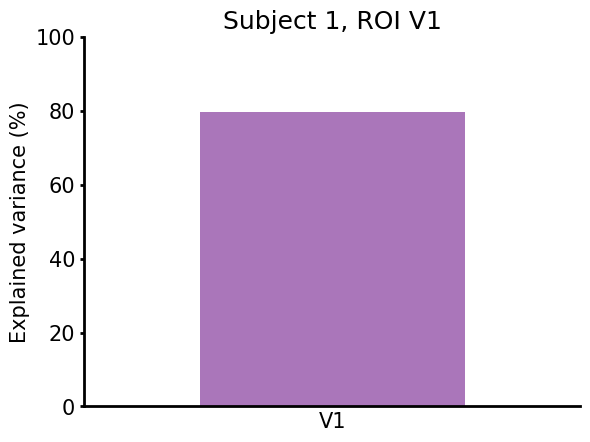

In [ ]:
# Load the encoding accuracy
metadata_dir = os.path.join(data_dir, 'modality-fmri', 'train_dataset-nsd',
    'model-fwrf', 'imageset-'+imageset, 'synthetic_neural_responses_metadata_'+
    'sub-0'+str(sub)+'_roi-'+roi+'.npy')
metadata = np.load(metadata_dir, allow_pickle=True).item()

# Plot parameters
fontsize = 15
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['font.size'] = fontsize
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.major.size'] = 3
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 3
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.bottom'] = True
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['lines.markersize'] = 3
colors = [(170/255, 118/255, 186/255)]

# Plot the mean noise-ceiling normalized encoding accuracy
encoding_acc = np.mean(metadata['encoding_models']['encoding_accuracy']\
    ['noise_normalized_encoding']) * 100
plt.plot()
plt.bar(1, encoding_acc, color=colors[0])
plt.ylabel('Explained variance (%)',
    fontsize=fontsize)
plt.ylim(bottom=0, top=100)
plt.xlabel(roi, fontsize=fontsize)
plt.xticks([])
plt.xlim(left=0.25, right=1.75);
title = 'Subject ' + str(sub) + ', ROI ' + roi
plt.title(title);

Next, you will plot the voxel-wise encoding accuracy scores (`r2` scores) against the corresponding `noise_ceiling` scores, on a scatterplot.

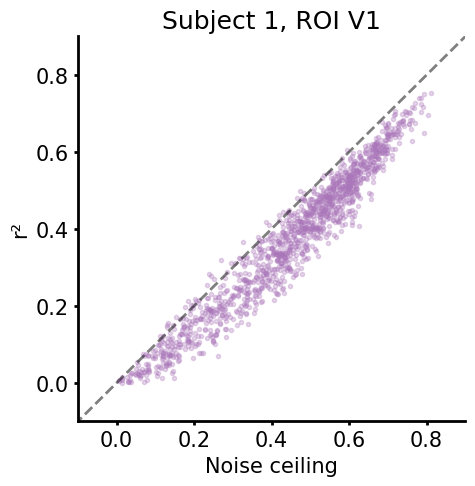

In [ ]:
r2 = metadata['encoding_models']['encoding_accuracy']['r2']
noise_ceiling = metadata['encoding_models']['encoding_accuracy']['noise_ceiling']

plt.figure(figsize=(5,5))
plt.plot(np.arange(-1,1.1,.1), np.arange(-1,1.1,.1), '--k', linewidth=2,
    alpha=.5)
plt.scatter(noise_ceiling, r2, color=colors[0], alpha=.3)
plt.ylabel('r²', fontsize=fontsize)
plt.ylim(bottom=-.1, top=.9)
plt.xlabel('Noise ceiling', fontsize=fontsize)
plt.xlim(left=-.1, right=.9);
title = 'Subject ' + str(sub) + ', ROI ' + roi
plt.title(title);

## 1.3 | Load the in silico fMRI responses

Now you will load and visualize the in silico fMRI responses, and print their shape.

In [ ]:
# Load the in silico fMRI responses
fmri_dir = os.path.join(data_dir, 'modality-fmri', 'train_dataset-nsd',
    'model-fwrf', 'imageset-'+imageset, 'synthetic_neural_responses_sub-0'+
	str(sub)+'_roi-'+roi+'.h5')
insilico_fmri = h5py.File(fmri_dir, 'r').get('synthetic_neural_responses')

# Visualize the in silico fMRI data dimensions
print('In silico fMRI data shape:')
print(insilico_fmri.shape)
print('(Images × Voxels)')

In silico fMRI data shape:
(73000, 1350)
(Images × Voxels)


## 1.4 | Link the in silico fMRI responses to the corresponding images

Here you will match the in silico fMRI responses to the corresponding images. You will start by accessing the image sets. Since the [NSD][nsd], [ILSVRC-2012][imagenet], and [THINGS][things] image sets are organized following different directory structures, you will access each of them in a different way.

<font color='red'><b>NOTE:</b></font> **Prior to using the NSD images you are required to fill out the [NSD Data Access Agreement][nsd_access].**

[nsd_access]: https://forms.gle/eT4jHxaWwYUDEf2i9
[nsd]: https://naturalscenesdataset.org/
[imagenet]: https://www.image-net.org/challenges/LSVRC/2012/index.php
[things]: https://things-initiative.org/

In [ ]:
# Access the image sets
if imageset == 'nsd':
    imageset_dir = os.path.join(data_dir, 'imagesets', 'imageset-nsd',
        'nsd_stimuli.hdf5')
    images = h5py.File(imageset_dir, 'r')
    images = images.get('imgBrick')
elif imageset == 'imagenet_val':
    imageset_dir = os.path.join(data_dir, 'imagesets', 'imageset-imagenet_val')
    images = torchvision.datasets.ImageNet(root=imageset_dir, split='val')
elif imageset == 'things':
    images = metadata['things_labels']['image_paths']

Here you can choose an image (indexing is zero-based), and link it to the corresponding in silico fMRI response.

In [ ]:
# Choose the image
if imageset == 'nsd':
    nsd_img = 0 # @param {type:"slider", min:0, max:72999, step:1}
    img_idx = nsd_img
elif imageset == 'imagenet_val':
    imagenet_img = 0 # @param {type:"slider", min:0, max:49999, step:1}
    img_idx = imagenet_img
elif imageset == 'things':
    things_img = 0 # @param {type:"slider", min:0, max:26106, step:1}
    img_idx = things_img

# Link the image to the corresponding in silico fMRI response
print('In silico fMRI image response shape:')
print(insilico_fmri[img_idx].shape)
print('(Voxels)')

In silico fMRI image response shape:
(1350,)
(Voxels)


And now you will load and visualize the image you chose, along with optional metadata (e.g., image category).

Since the ILSVRC-2012 images are rectangular, we center cropped them to square format prior to feeding them to encoding models to genertate their corresponding in silico fMRI responses. Here you will apply the same center cropping when loading these images. The NSD and THINGS images are already in square format, and therefore do not require any cropping.

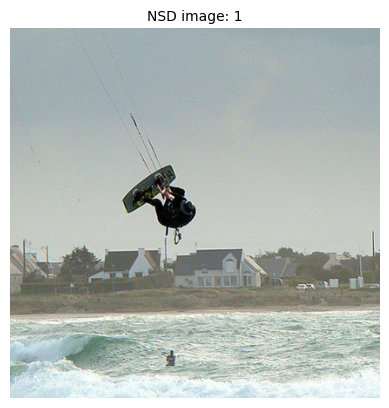

In [ ]:
# Load the selected image
if imageset == 'nsd':
    img = images[img_idx]
elif imageset == 'imagenet_val':
    img, _ = images.__getitem__(img_idx)
    transform = trn.Compose([trn.CenterCrop(min(img.size))])
    img = transform(img)
elif imageset == 'things':
    img_dir = os.path.join(data_dir, 'imagesets', 'imageset-things', 'images',
        images[img_idx])
    img = Image.open(img_dir).convert('RGB')

# Visualize the image (along with optional metadata)
plt.figure()
plt.axis('off')
plt.imshow(img)
if imageset == 'nsd':
    title = 'NSD image: ' + str(img_idx+1)
elif imageset == 'imagenet_val':
    label_number = metadata['imagenet_val_labels']['label_number'][img_idx]
    label_name = metadata['imagenet_val_labels']['label_names'][label_number]
    title = 'ILSVRC-2012 validation image: ' + str(img_idx+1) + \
        '\nCategory number: ' + str(label_number+1) + \
        '\nCategory name: ' + label_name
elif imageset == 'things':
    object_concept_number = \
        metadata['things_labels']['image_concept_index'][img_idx]
    object_concept_name = \
        metadata['things_labels']['unique_id'][object_concept_number]
    file_name = \
        metadata['things_labels']['image_paths'][img_idx]
    title = 'THINGS image: ' + str(img_idx+1) + \
        '\nObject concept number: ' + str(object_concept_number+1) + \
        '\nObject concept name: ' + object_concept_name + \
        '\nFile name: ' + file_name
plt.title(title, fontsize=10);

# 2 | Univariate RNC

Now you will use univariate RNC to investigate representational relationships between the univariate responses of two ROIs of your choice, out of the 23 available visual ROIs (e.g., V1 vs. V4, FFA-1 vs. PPA, EBA vs. OWFA). Univariate RNC jointly controls ROI pairs by selecting controlling images that align or disentangle their univariate responses, thus indicating shared or unique representational content, respectively.

Alignment consists in two neural control conditions where the univariate responses of both ROIs are either driven or suppressed. Disentanglement consists in two neural control conditions where the univariate response of one ROI is driven while the response of the other ROI is suppressed, and vice versa.

You will apply univariate RNC on the in silico fMRI responses of the 8 NSD subjects for all images from one of three image sets (the 73,000 images from NSD, the 50,000 images from the ILSVRC-2012 validation split, or the 26,107 images from the THINGS database). You will use the in silico fMRI responses of a subset of these subjects to select the controlling images that either align or disentangle the univariate responses of the two chosen ROIs. You will then cross-validate these controlling images on the in silico univariate fMRI responses of the remaining subjects.

## 2.0 | Univariate RNC algorithmic description

![](https://drive.google.com/uc?export=view&id=1xzfp9duHM9EUiZ1LqFldywolCJJorDh2)

Univariate RNC searches for stimulus images leading to aligned or disentangled in silico univariate fMRI responses of two visual areas. Images (e.g., the 73,000 NSD images) are fed to the trained encoding models of two areas, and the resulting in silico fMRI responses averaged across voxels, obtaining a one-dimensional univariate response vector of length 73,000, for each area. The univariate response vectors of the two areas are either summed (alignment) or subtracted (disentanglement), the sum/difference scores ranked, and the controlling images leading to highest and lowest scores are kept. This results in four sets of controlling images, each set corresponding to a different neural control condition. The controlling images from the sum vector lead to two neural control conditions in which both areas have aligned univariate responses (i.e., images that either drive or suppress the responses of both areas), whereas the controlling images from the difference vector lead to two neural control conditions in which both areas have disentangled univariate responses (i.e. images that drive the responses of one area while suppressing the responses of the other area, and vice versa).

## 2.1 | Hyperparameters and random seed setup

Here you can edit the univariate RNC hyperparameters:
* `roi_1`: string indicating the first ROI of the pairwise ROI  comparison.
* `roi_2`: string indicating the second ROI of the pairwise ROI comparison.
* `select_subjects`: list containing the indices of the subjects used to select the controlling images (out of the 8 NSD subjects).
* `eval_subjects`: list containing the indices of the subjects used to evaluate the controlling images (out of the 8 NSD subjects); for cross-validation, this list should contain different subjects than the `select_subjects` variable.
* `imageset`: string with the image set used; you will apply univariate RNC on the in silico fMRI responses for all images included in this image set.
* `ncsnr_threshold`: float (between 0 and 1) indicating the noise ceiling signal-to-noise-ratio threshold of each voxel; only voxels with noise ceiling signal-to-noise-ratio scores above this threshold will be used to compute the  in silico univariate fMRI responses (so to prevent results being biased toward noisy voxels).
* `n_control_images`: integer indicating how many controlling images are selected for each neural control condition.
* `null_dist_samples`: integer indicating the number of samples used to compute the in silico univariate fMRI response null distribution.

In [ ]:
# Used ROIs
roi_1 = 'V1' # @param ["V1", "V2", "V3", "hV4", "EBA", "FBA-2", "OFA", "FFA-1", "FFA-2", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}
roi_2 = 'hV4' # @param ["V1", "V2", "V3", "hV4", "EBA", "FBA-2", "OFA", "FFA-1", "FFA-2", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

# Selection and evaluation subjects
select_subjects = [2, 3, 4, 5, 6, 7, 8] # @param {allow-input: true}
eval_subjects = [1] # @param {allow-input: true}

# Imageset
imageset = "nsd" # @param ["nsd", "imagenet_val", "things"] {allow-input: true}

# Other hyperparameters
ncsnr_threshold = 0.5 # @param {type:"slider", min:0, max:1, step:0.01}
n_control_images = 25 # @param {type:"slider", min:1, max:1000, step:1}
null_dist_samples = 10000 # @param ["100", "1000", "10000", "100000"] {type:"raw", allow-input: true}

Some of the following blocks of code involve stochastic operations. You can set a random seed to ensure reproducible results across multiple runs.

In [ ]:
seed = 20200220
np.random.seed(seed)
random.seed(seed)

## 2.2 | Load the in silico fMRI responses, and transform them into univariate responses

Now you will load the in silico fMRI responses for the selected image set and ROIs and average them across voxels, obtaining the ROI-wise univariate responses for these images. To reduce the impact of noisy voxels on the ensuing univariate RNC image selection process, the averaging only uses voxels with noise ceiling signal-to-noise-ratio scores above the `ncsnr_threshold` variable.

During loading the in silico fMRI data is already split into selection and evaluation partitions based on the `select_subjects` and `eval_subjects` variables, and averaged across all subjects within each partition. The purpose of this averaging is to boost the signal common across subjects, thus increasing the generalizability of results.

This will results in 2-D in silico univariate fMRI responses arrays of shape (2 ROIs × N images), for both the selection and evaluation subjects.

In [ ]:
# Get number of images and ROIs
if imageset == 'nsd':
    n_images = 73000
elif imageset == 'imagenet_val':
    n_images = 50000
elif imageset == 'things':
    n_images = 26107
n_rois = 2

# Univariate response 3-D arrays of shape:
# (N subjects × 2 ROIs × N Images)
uni_fmri_select = np.zeros((len(select_subjects), n_rois, n_images),
    dtype=np.float32)
uni_fmri_eval = np.zeros((len(eval_subjects), n_rois, n_images),
    dtype=np.float32)

# Load the in silico fMRI responses
all_subjects = list(set(select_subjects).union(set(eval_subjects)))
for r, roi in enumerate([roi_1, roi_2]):
    idx_select = 0
    idx_eval = 0
    for s, sub in tqdm(enumerate(all_subjects), desc=roi, total=len(all_subjects)):

        # Load the metadata
        metadata_dir = os.path.join(data_dir, 'modality-fmri',
            'train_dataset-nsd', 'model-fwrf', 'imageset-'+imageset,
            'synthetic_neural_responses_metadata_'+'sub-0'+str(sub)+'_roi-'+roi+
            '.npy')
        metadata = np.load(metadata_dir, allow_pickle=True).item()

        # Load the in silico fMRI responses
        fmri_dir = os.path.join(data_dir, 'modality-fmri', 'train_dataset-nsd',
            'model-fwrf', 'imageset-'+imageset, 'synthetic_neural_responses_'
            'sub-0'+str(sub)+'_roi-'+roi+'.h5')
        fmri = h5py.File(fmri_dir, 'r').get('synthetic_neural_responses')

        # Average the responses across voxels (using only voxels with noise
        # ceiling signal-to-noise ratio scores above the selected threshold)
        voxel_idx = metadata['fmri']['ncsnr'] > ncsnr_threshold
        if sub in select_subjects:
            uni_fmri_select[idx_select,r] = np.nanmean(fmri[:,voxel_idx], 1)
            idx_select += 1
        if sub in eval_subjects:
            uni_fmri_eval[idx_eval,r] = np.nanmean(fmri[:,voxel_idx], 1)
            idx_eval += 1
        del fmri

# Average the data across subjects (within partitions)
uni_fmri_select = np.mean(uni_fmri_select, 0)
uni_fmri_eval = np.mean(uni_fmri_eval, 0)

# Print the selection partition univariate fMRI responses shape
print('\n\nSelection partition in silico univariate fMRI responses shape:')
print(uni_fmri_select.shape)
print('(ROIs × Images)')

# Print the evaluation partition univariate fMRI responses shape
print('\nEvaluation partition in silico univariate fMRI responses shape:')
print(uni_fmri_eval.shape)
print('(ROIs × Images)')

hV4: 100%|██████████| 8/8 [01:29<00:00, 11.19s/it]



Selection partition in silico univariate fMRI responses shape:
(2, 73000)
(ROIs × Images)

Evaluation partition in silico univariate fMRI responses shape:
(2, 73000)
(ROIs × Images)


## 2.3 | Univariate RNC baseline

Next, you will use the `select_subjects` in silico univariate fMRI responses (from the `uni_fmri_select` variable) to select the images leading to baseline univariate responses, for each of the two chosen ROIs. You will later use the in silico fMRI univariate responses for the baseline images (i) to select the controlling images, and (ii) as a baseline against which to test the in silico fMRI univariate responses from the controlling images selected through univariate RNC.

To compute the baseline of each ROI, you will randomly select a batch of X images (out of all available images from the chosen image set, where X is defined by the `n_control_images` variable) and average the corresponding in silico univariate fMRI responses across these X images, resulting in one score indicating the mean in silico fMRI response for the image batch. By repeating this step N times (where N is defined by the `null_dist_samples` variable) you will create the univariate RNC null distribution, and then select the X images with scores closest to the null distribution's mean. The mean univariate response score across these X images provides the ROI-wise univariate response baseline. Furthermore, you will then visually compare these baseline images with the controlling images selected by univariate RNC.

In [ ]:
# Null distribution images 2-D array of shape:
# (N Null distribution samples × Y Images)
null_dist_images = np.zeros((null_dist_samples, n_control_images),
    dtype=np.int32)
# Null distribution scores 2-D arrays of shape:
# (N Null distribution samples × 2 ROIs)
null_dist_scores_select = np.zeros((null_dist_samples, n_rois),
    dtype=np.float32)

# Create the null distribution
for i in tqdm(range(null_dist_samples), desc='Null distribution samples'):
    sample = resample(np.arange(n_images), replace=False,
        n_samples=n_control_images)
    sample.sort()
    null_dist_images[i] = sample
    for r in range(n_rois):
        null_dist_scores_select[i,r] = np.mean(uni_fmri_select[r,sample])
    del sample

# Select the image sample closest to the selection split null distribution mean,
# and use its score as the univariate RNC baseline
baseline_scores = np.zeros((n_rois))
for r in range(n_rois):
    null_dist_mean = np.mean(null_dist_scores_select[:,r])
    idx = np.argsort(abs(null_dist_scores_select[:,r] - null_dist_mean))[0]
    baseline_scores[r] = null_dist_scores_select[idx,r]

Null distribution samples: 100%|██████████| 10000/10000 [00:18<00:00, 540.66it/s]


## 2.4 | Select the controlling images using the in silico univariate fMRI responses of the selection subjects

Now you will use the `select_subjects` in silico univariate fMRI responses to select the controlling images, that is, the images aligning and disentangling the in silico fMRI univariate responses of two ROIs.

You will sum (i.e., align) and subtract (i.e., disentangle) the 2-D in silico univariate fMRI responses arrays of the two ROIs (computed in section 2.2), and rank the resulting sum/difference scores. You will then retain the X controlling images with the highest and lowest rank, while at the same time resulting in in silico univariate fMRI responses higher (or lower, depending on the neural control condition) than the ROIs' univariate response baselines by a margin (so to prevent solutions where the controlling images do not drive or suppress the in silico fMRI responses beyond baseline). Note that if the margin is large, there might not be controlling images with high (or low) enough in silico univariate fMRI responses.

In [ ]:
# Univariate response score margin used to constrain the selection of the
# control images
margin = 0.04

# Select the top N images that align the in silico univariate fMRI responses
# of the two ROIs (i.e., that lead both ROIs having either high or low
# univariate responses).
roi_sum = uni_fmri_select[0] + uni_fmri_select[1]
# 1st neural control condition: images with high univariate responses for both
# ROIs
high_1_high_2 = np.argsort(roi_sum)[::-1]
# Ignore images conditions with univariate responses below the baseline scores
# (plus a margin)
idx_bad_roi_1 = uni_fmri_select[0][high_1_high_2] < \
    (baseline_scores[0] + margin)
idx_bad_roi_2 = uni_fmri_select[1][high_1_high_2] < \
    (baseline_scores[1] + margin)
idx_bad = np.where(idx_bad_roi_1 + idx_bad_roi_2)[0]
high_1_high_2 = np.delete(high_1_high_2, idx_bad)[:n_control_images]
# 2nd neural control condition: images with low univariate responses for both
# ROIs
low_1_low_2 = np.argsort(roi_sum)
# Ignore images conditions with univariate responses below the baseline scores
# (minus a margin)
idx_bad_roi_1 = uni_fmri_select[0][low_1_low_2] > \
    (baseline_scores[0] - margin)
idx_bad_roi_2 = uni_fmri_select[1][low_1_low_2] > \
    (baseline_scores[1] - margin)
idx_bad = np.where(idx_bad_roi_1 + idx_bad_roi_2)[0]
low_1_low_2 = np.delete(low_1_low_2, idx_bad)[:n_control_images]

# Select the top N images that differentiate the in silico univariate fMRI
# responses of the two ROIs (i.e., that lead one ROI having high responses
# and the other ROI low responses, or vice versa).
roi_diff = uni_fmri_select[0] - uni_fmri_select[1]
# 3rd neural control condition: images with high univariate responses for ROI 1,
# and low univariate responses for ROI 2
high_1_low_2 = np.argsort(roi_diff)[::-1]
# Ignore images conditions with univariate responses below (ROI 1) or above
# (ROI 2) the baseline scores (plus/minus a margin)
idx_bad_roi_1 = uni_fmri_select[0][high_1_low_2] < \
    (baseline_scores[0] + margin)
idx_bad_roi_2 = uni_fmri_select[1][high_1_low_2] > \
    (baseline_scores[1] - margin)
idx_bad = np.where(idx_bad_roi_1 + idx_bad_roi_2)[0]
high_1_low_2 = np.delete(high_1_low_2, idx_bad)[:n_control_images]
# 4th neural control condition: images with low univariate responses for ROI 1,
# and high univariate responses for ROI 2
low_1_high_2 = np.argsort(roi_diff)
# Ignore images conditions with univariate responses above (ROI 1) or below
# (ROI 2) the baseline scores (minus/plus a margin)
idx_bad_roi_1 = uni_fmri_select[0][low_1_high_2] > \
    (baseline_scores[0] - margin)
idx_bad_roi_2 = uni_fmri_select[1][low_1_high_2] < \
    (baseline_scores[1] + margin)
idx_bad = np.where(idx_bad_roi_1 + idx_bad_roi_2)[0]
low_1_high_2 = np.delete(low_1_high_2, idx_bad)[:n_control_images]

## 2.5 | Evaluate the controlling images on the in silico univariate fMRI responses of the evaluation subjects

Now that you selected the controlling images, you will check whether their neural control effect generalizes to the in silico univariate fMRI responses of the `eval_subjects`, that is, whether they drive/suppress the evaluation subjects' univariate responses beyond baseline.

For this, you will plot the evaluation subjects' in silico univariate fMRI responses to the controlling and baseline images on a scatter plot. Each scatter plot axis represents the univariate response of one ROI. The black dots correspond to the in silico univariate fMRI responses to all images, while the colored dots represent to responses to the (cross-validated) controlling images. The vertical and horizontal dashed white lines indicate the responses to the (cross-validated) baseline images for the corresponding ROI.

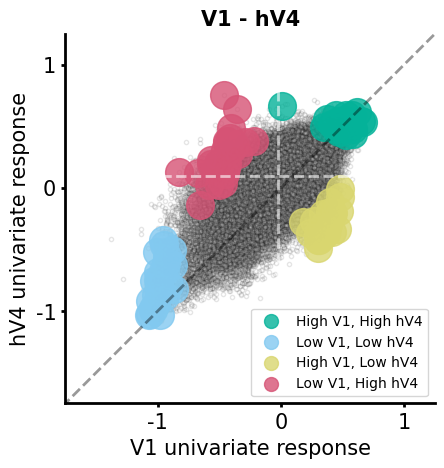

In [ ]:
# Get the evaluation subjects' in silico univariate fMRI responses for the
# controlling images from the four neural control conditions
high_1_high_2_images_score_eval = uni_fmri_eval[:,high_1_high_2]
low_1_low_2_images_score_eval = uni_fmri_eval[:,low_1_low_2]
high_1_low_2_images_score_eval = uni_fmri_eval[:,high_1_low_2]
low_1_high_2_images_score_eval = uni_fmri_eval[:,low_1_high_2]

# Get the evaluation subjects' in silico univariate fMRI responses for the
# baseline images
baseline_score_eval = np.zeros((n_rois))
for r in range(n_rois):
    null_dist_mean = np.mean(null_dist_scores_select[:,r])
    idx = np.argsort(abs(null_dist_scores_select[:,r] - null_dist_mean))[0]
    baseline_score_eval[r] = np.mean(uni_fmri_eval[r,null_dist_images[idx]])

# Plot parameters
fontsize = 15
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['font.size'] = fontsize
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.major.size'] = 3
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 3
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.bottom'] = True
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['lines.markersize'] = 3
s = 400
colors = [(4/255, 178/255, 153/255), (130/255, 201/255, 240/255),
	(217/255, 214/255, 111/255), (214/255, 83/255, 117/255)]

# Plot the results
plt.figure()
# Diagonal dashed line
plt.plot(np.arange(-3,3), np.arange(-3,3), '--k', linewidth=2,
    alpha=.4, label='_nolegend_')
# Null distribution dashed lines
plt.plot([baseline_score_eval[0], baseline_score_eval[0]], [-3, 3], '--w',
    linewidth=2, alpha=.6, label='_nolegend_')
plt.plot([-3, 3], [baseline_score_eval[1], baseline_score_eval[1]], '--w',
    linewidth=2, alpha=.6, label='_nolegend_')
# Scatter plot of all images
plt.scatter(uni_fmri_eval[0], uni_fmri_eval[1], c='w', alpha=.1,
    edgecolors='k', label='_nolegend_');
# Scatter plot of the 1st neural control condition images
plt.scatter(high_1_high_2_images_score_eval[0],
    high_1_high_2_images_score_eval[1], color=colors[0], s=s, alpha=0.8)
# Scatter plot of the 2nd neural control condition images
plt.scatter(low_1_low_2_images_score_eval[0],
    low_1_low_2_images_score_eval[1], color=colors[1], s=s, alpha=0.8)
# Scatter plot of the 3rd neural control condition images
plt.scatter(high_1_low_2_images_score_eval[0],
    high_1_low_2_images_score_eval[1], color=colors[2], s=s, alpha=0.8)
# Scatter plot of the 4th neural control condition images
plt.scatter(low_1_high_2_images_score_eval[0],
    low_1_high_2_images_score_eval[1], color=colors[3], s=s, alpha=0.8)
# Title
title = roi_1 + ' - ' + roi_2
plt.title(title, fontsize=fontsize, weight='bold')
# Aspect
plt.gca().set_aspect('equal')
# x-axis
xlabel = roi_1 + ' univariate response'
plt.xlabel(xlabel, fontsize=fontsize)
ticks = [-2, -1, 0, 1, 2]
labels = [-2, -1, 0, 1, 2]
plt.xticks(ticks=ticks, labels=labels)
plt.xlim(left=-1.75, right=1.25)
# y-axis
ylabel = roi_2 + ' univariate response'
plt.ylabel(ylabel, fontsize=fontsize)
plt.yticks(ticks=ticks, labels=labels)
plt.ylim(bottom=-1.75, top=1.25)
# Legend
legend = ['High '+roi_1+', High '+roi_2,
    'Low '+roi_1+', Low '+roi_2,
    'High '+roi_1+', Low '+roi_2,
    'Low '+roi_1+', High '+roi_2]
plt.legend(legend, loc=4, ncol=1, fontsize=10, markerscale=.5);

## 2.6 | Visualize the controlling images

Finally, here you will visualize the controlling images from the four neural control conditions.

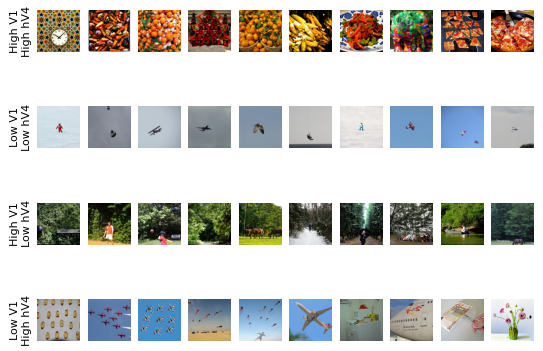

In [ ]:
# Access the image sets
if imageset == 'nsd':
    imageset_dir = os.path.join(data_dir,'imagesets', 'imageset-nsd',
        'nsd_stimuli.hdf5')
    images = h5py.File(imageset_dir, 'r')
    images = images.get('imgBrick')
elif imageset == 'imagenet_val':
    imageset_dir = os.path.join(data_dir, 'imagesets', 'imageset-imagenet_val')
    images = torchvision.datasets.ImageNet(root=imageset_dir, split='val')
elif imageset == 'things':
    images = metadata['things_labels']['image_paths']

# Function to load the selected image
def load_img(imageset, images, img_idx):
    if imageset == 'nsd':
        img = images[img_idx]
    elif imageset == 'imagenet_val':
        img, _ = images.__getitem__(img_idx)
        transform = trn.Compose([trn.CenterCrop(min(img.size))])
        img = transform(img)
    elif imageset == 'things':
        img_dir = os.path.join(data_dir, 'imagesets', 'imageset-things',
            'images', images[img_idx])
        img = Image.open(img_dir).convert('RGB')
    return img

# Plot parameters
fontsize = 8
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['font.size'] = fontsize
matplotlib.rcParams['axes.spines.left'] = False
matplotlib.rcParams['axes.spines.bottom'] = False
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

# Create the figure
control_conditions = 4
rows = control_conditions
max_images_per_condition = 10
if n_control_images < max_images_per_condition:
    columns = n_control_images
else:
    columns = max_images_per_condition
fig, axs = plt.subplots(rows, columns)

# Plot the images
for c in range(columns):
    # 1st neural control condition images
    img = load_img(imageset, images, high_1_high_2[c])
    axs[0,c].imshow(img)
    axs[0,c].set_xticks([])
    axs[0,c].set_yticks([])
    # 2nd neural control condition images
    img = load_img(imageset, images, low_1_low_2[c])
    axs[1,c].imshow(img)
    axs[1,c].set_xticks([])
    axs[1,c].set_yticks([])
    # 3rd neural control condition images
    img = load_img(imageset, images, high_1_low_2[c])
    axs[2,c].imshow(img)
    axs[2,c].set_xticks([])
    axs[2,c].set_yticks([])
    # 4th neural control condition images
    img = load_img(imageset, images, low_1_high_2[c])
    axs[3,c].imshow(img)
    axs[3,c].set_xticks([])
    axs[3,c].set_yticks([])
    # y-labels
    if c == 0:
        axs[0,c].set_ylabel('High '+roi_1+'\nHigh '+roi_2)
        axs[1,c].set_ylabel('Low '+roi_1+'\nLow '+roi_2)
        axs[2,c].set_ylabel('High '+roi_1+'\nLow '+roi_2)
        axs[3,c].set_ylabel('Low '+roi_1+'\nHigh '+roi_2)